# Análise de Impacto da Lei de Clubes de Tiro Próximos a Escolas

### Objetivo
Demonstrar o impacto do Decreto nº 12.345/2024, que veio substituir o Decreto n° 11.615/2023, regulamentando clubes de tiro num raio de 1 km de escolas, em 4 cidades do Brasil (São Paulo, Rio de Janeiro, Brasília e Salvador).

### Ferramentas
- OSMnx (para busca de dados do OpenStreetMap)
- GeoPandas (para manipular dados espaciais)
- Matplotlib (para plotar os resultados)

## Importações

In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import shapely.geometry as geom
from shapely.geometry import box, Point, MultiPolygon, Polygon, MultiLineString
from shapely.ops import polygonize, unary_union
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

## 1. Funções auxiliares

In [2]:
def get_city_boundary(place_name):
    """
    Obtém o limite territorial de uma cidade, tratando tanto cidades costeiras quanto continentais.
    Utiliza o centro da cidade para determinar se o maior polígono deve ser mantido.
    Sempre retorna um único polígono mesclado no sistema WGS84 (EPSG:4326).
    
    Argumentos:
        nome_local (str): Nome do local (exemplo: "Salvador, Bahia, Brasil")
    
    Retorna:
        shapely.geometry.Polygon: Um único polígono representando o limite mesclado da cidade em WGS84
    """
    # Pegando o centro da cidade 
    try:
        center_tags = {"place": "city"}
        gdf_center = ox.features.features_from_place(place_name, center_tags)
        city_center = gdf_center.geometry.iloc[0]
    except Exception as e:
        print(f"Warning: Could not get city center: {e}")
        city_center = None

    # Encontrando município e checando se tem costa
    tags = {"natural": "coastline", "place": "municipality"}
    try:
        gdf = ox.features.features_from_place(place_name, tags)
        has_coastline = any(gdf["natural"] == "coastline")
        # Se tiver, talvez seja necessário remover água
        if has_coastline:
            mask_city = gdf["name"] == place_name.split(",")[0].strip()
            mask_coast = gdf["natural"] == "coastline"
            gdf_utm = ox.projection.project_gdf(gdf.loc[mask_city | mask_coast])
            if city_center is not None:
                center_utm = gpd.GeoSeries([city_center], crs="EPSG:4326").to_crs(gdf_utm.crs).iloc[0]
            gdf_utm.loc[mask_city, "geometry"] = gdf_utm.loc[mask_city, "geometry"].boundary
            gdf_land = gpd.GeoDataFrame(geometry=gdf_utm.polygonize(), crs=gdf_utm.crs)
            # Encontrando o maior polígono e apagando se não contiver o centro da cidade.
            largest_idx = gdf_land.area.idxmax()
            largest_polygon = gdf_land.loc[largest_idx, "geometry"]
            if city_center is not None:
                if largest_polygon.contains(center_utm):
                    polygon = unary_union(gdf_land.geometry)
                else:
                    polygon = unary_union(gdf_land.drop(largest_idx).geometry)
            else:
                polygon = unary_union(gdf_land.drop(largest_idx).geometry)
            source_crs = gdf_utm.crs
        else:
            # Fallback for inland cities
            city_gdf = ox.geocode_to_gdf(place_name)
            geom = city_gdf.geometry.iloc[0]
            if isinstance(geom, MultiPolygon):
                polygon = unary_union(geom)
            else:
                polygon = geom
            source_crs = city_gdf.crs
            
    except Exception as e:
        try:
            city_gdf = ox.geocode_to_gdf(place_name)
            geom = city_gdf.geometry.iloc[0]
            if isinstance(geom, MultiPolygon):
                polygon = unary_union(geom)
            else:
                polygon = geom
            source_crs = city_gdf.crs
        except Exception as e:
            print(f"Failed to get boundary: {e}")
            return None

    # Garantindo que o resultado final está com EPSG 4326
    if polygon is not None:
        if source_crs != "EPSG:4326":
            polygon = gpd.GeoSeries([polygon], crs=source_crs).to_crs("EPSG:4326").iloc[0]
        return polygon
    return None

def get_natural_areas(boundary_polygon):
    """
    Obtém todas as áreas naturais dentro dos limites de uma cidade, incluindo áreas verdes, 
    parques e corpos d'água.

    A função busca diversos tipos de áreas naturais usando tags específicas do OpenStreetMap,
    processa as geometrias e retorna uma representação unificada dessas áreas.

    Argumentos:
        boundary_polygon (shapely.geometry.Polygon): Polígono representando os limites da cidade

    Retorna:
        geopandas.GeoDataFrame: Um GeoDataFrame contendo as áreas naturais mescladas em WGS84 (EPSG:4326)
    """
    # Tags para áreas naturais
    tags = {'natural': ['wood', 'grassland', 'scrub'],
            'leisure': ['park', 'nature_reserve'],
            'landuse': ['forest', 'grass', 'reservoir', 'landfill'],
            'water': ['lake', 'reservoir', 'pond', 'dam', 'river'],
            'aeroway': ['aerodrome']}
    natural_areas = []
    
    for key, values in tags.items():
        for value in values:
            try:
                gdf = ox.features_from_polygon(boundary_polygon, tags={key: value})
                if not gdf.empty:
                    gdf['area_type'] = f"{key}_{value}"
                    natural_areas.append(gdf)
            except Exception as e:
                continue
    if not natural_areas:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")
    
    # Combina todos os GeoDataFrames
    natural_areas_gdf = pd.concat(natural_areas, ignore_index=True)
    natural_areas_3857 = natural_areas_gdf.to_crs(epsg=3857)
    boundary_3857 = gpd.GeoDataFrame(geometry=[boundary_polygon], crs="EPSG:4326").to_crs(epsg=3857)
    # Simplifica geometrias e faz o clip
    dissolved = natural_areas_3857.geometry.union_all()
    dissolved = dissolved.simplify(10).buffer(1).buffer(1)
    final_geom = dissolved.intersection(boundary_3857.geometry.iloc[0])
    natural_areas_gdf = gpd.GeoDataFrame(geometry=[final_geom], crs=3857).to_crs(epsg=4326)
    return natural_areas_gdf

def get_schools_in_city(boundary_polygon):
    """
    Obtém a localização de todas as escolas dentro dos limites de uma cidade usando dados 
    do OpenStreetMap.

    A função busca estabelecimentos marcados com a tag 'amenity=school', processa suas 
    geometrias e retorna suas localizações como pontos centroides.

    Argumentos:
        boundary_polygon (shapely.geometry.Polygon): Polígono representando os limites da cidade

    Retorna:
        geopandas.GeoDataFrame: Um GeoDataFrame contendo os pontos de localização das escolas 
                               no sistema de coordenadas Web Mercator (EPSG:3857)
    """
    # Faz a query ao Overpass usando OSMnx
    # A função 'geometries_from_polygon' foi escolhida para buscar todas as 'ways' e 'nodes' referentes a amenity=school
    tags = {"amenity": "school"}
    schools_gdf = ox.features_from_polygon(boundary_polygon, tags=tags)
    # Filtra para garantir que a geometria não seja nula
    schools_gdf = schools_gdf[~schools_gdf.geometry.is_empty]    
    # Ajusta para um CRS padrão (epsg:3857)
    if schools_gdf.crs is None:
        schools_gdf = schools_gdf.set_crs(epsg=3857)
    else:
        schools_gdf = schools_gdf.to_crs(epsg=3857)
    schools_gdf["geometry"] = schools_gdf.geometry.centroid

    return schools_gdf

def create_1km_buffer_around_schools(schools_gdf):
    """
    Cria uma área de influência (buffer) de 1 quilômetro ao redor de cada escola e 
    unifica todas essas áreas em um único polígono.

    A função converte as coordenadas para um sistema métrico apropriado, cria os buffers
    e dissolve todas as áreas sobrepostas em uma única geometria.

    Argumentos:
        schools_gdf (geopandas.GeoDataFrame): GeoDataFrame contendo a localização das escolas

    Retorna:
        geopandas.GeoDataFrame: Um GeoDataFrame contendo o polígono unificado dos buffers 
                               em WGS84 (EPSG:4326)
    """
    # Precisamos trabalhar em um CRS adequado para distância. Para simplificar
    # aqui vamos converter para o pseudo-Mercator (EPSG:3857) e usar metros como aproximação.
    schools_3857 = schools_gdf.to_crs(epsg=3857)
    # Cria buffer de 1000 metros
    schools_3857["buffer_1km"] = schools_3857.buffer(1000)
    # Dissolve todos os buffers em um único polígono
    union_buffer = schools_3857["buffer_1km"].geometry.union_all()
    buffer_gdf = gpd.GeoDataFrame(geometry=[union_buffer], crs=schools_3857.crs)
    # Retorna ao WGS84
    buffer_gdf = buffer_gdf.to_crs(epsg=4326)
    
    return buffer_gdf

## 2. Processamento principal

In [3]:
# Lista de cidades a analisar
cities = ["São Paulo, Brazil", "Rio de Janeiro, Brazil", "Plano Piloto, Brasília, Brazil", "Salvador, Brazil"]

# Resultados pro plot
results = []

for city_name in cities:
    print(f"Processando {city_name} ...")
    
    # 1) Obter boundary e área em km²
    city_polygon = get_city_boundary(city_name)
    city_3857 = gpd.GeoDataFrame(geometry=[city_polygon], crs="EPSG:4326").to_crs(epsg=3857)
    area_km2 = city_3857.area.iloc[0] / 1e6
    print(f"  -> Área aproximada: {area_km2:.2f} km²")
    minx, miny, maxx, maxy = city_polygon.bounds
    print("  -> Bounding Box da cidade:")
    print(f"       Inferior-Esquerdo : ({minx:.6f}, {miny:.6f})       Inferior-Direito  : ({maxx:.6f}, {miny:.6f})")
    print(f"       Superior-Esquerdo : ({minx:.6f}, {maxy:.6f})       Superior-Direito  : ({maxx:.6f}, {maxy:.6f})")

    # 1.1) Obter áreas verdes
    natural_areas = get_natural_areas(city_polygon)
    print(f"  -> {len(natural_areas)} áreas naturais encontradas em {city_name}")

    # 2) Obter escolas
    schools_gdf = get_schools_in_city(city_polygon)
    print(f"  -> {len(schools_gdf)} escolas encontradas em {city_name}")
    
    # Se houver ao menos 1 escola, printar seu centróide
    if not schools_gdf.empty:
        school_centroid = schools_gdf.to_crs(epsg=3857).iloc[0].geometry.centroid
        print(f"       Exemplo de uma escola - centróide em: ({school_centroid.x:.6f}, {school_centroid.y:.6f})")

    # Se não achar escolas, continue
    if schools_gdf.empty:
        print(f"  -> Nenhuma escola encontrada em {city_name}, possivelmente OSM incompleto.")
        gdf_city["newly_allowed"] = False
        results.append((city_name, city_polygon, city_minus_buffer, city_in_buffer, natural_areas))
        continue
    
    # 3) Criar buffer de 1km em volta das escolas
    buffer_1km_gdf = create_1km_buffer_around_schools(schools_gdf)
    buffer_1km_polygon = buffer_1km_gdf.geometry.iloc[0]

    # 4) Calcular áreas “fora” do buffer (always_allowed) e “dentro” do buffer (newly_allowed)
    city_minus_buffer = city_polygon.difference(buffer_1km_polygon)
    city_in_buffer = city_polygon.intersection(buffer_1km_polygon)
    results.append((city_name, city_polygon, city_minus_buffer, city_in_buffer, natural_areas))
    print("\n")

print("Processamento concluído.")

Processando São Paulo, Brazil ...
  -> Área aproximada: 1825.17 km²
  -> Bounding Box da cidade:
       Inferior-Esquerdo : (-46.826269, -24.007900)       Inferior-Direito  : (-46.365090, -24.007900)
       Superior-Esquerdo : (-46.826269, -23.357755)       Superior-Direito  : (-46.365090, -23.357755)
  -> 1 áreas naturais encontradas em São Paulo, Brazil
  -> 1426 escolas encontradas em São Paulo, Brazil
       Exemplo de uma escola - centróide em: (-5199074.526020, -2708842.523243)


Processando Rio de Janeiro, Brazil ...
  -> Área aproximada: 1423.45 km²
  -> Bounding Box da cidade:
       Inferior-Esquerdo : (-43.796252, -23.082705)       Inferior-Direito  : (-43.099081, -23.082705)
       Superior-Esquerdo : (-43.796252, -22.746088)       Superior-Direito  : (-43.099081, -22.746088)
  -> 1 áreas naturais encontradas em Rio de Janeiro, Brazil
  -> 1877 escolas encontradas em Rio de Janeiro, Brazil
       Exemplo de uma escola - centróide em: (-4806349.258804, -2622867.968604)


Pro

## 3. Plot dos resultados pras cidades selecionadas

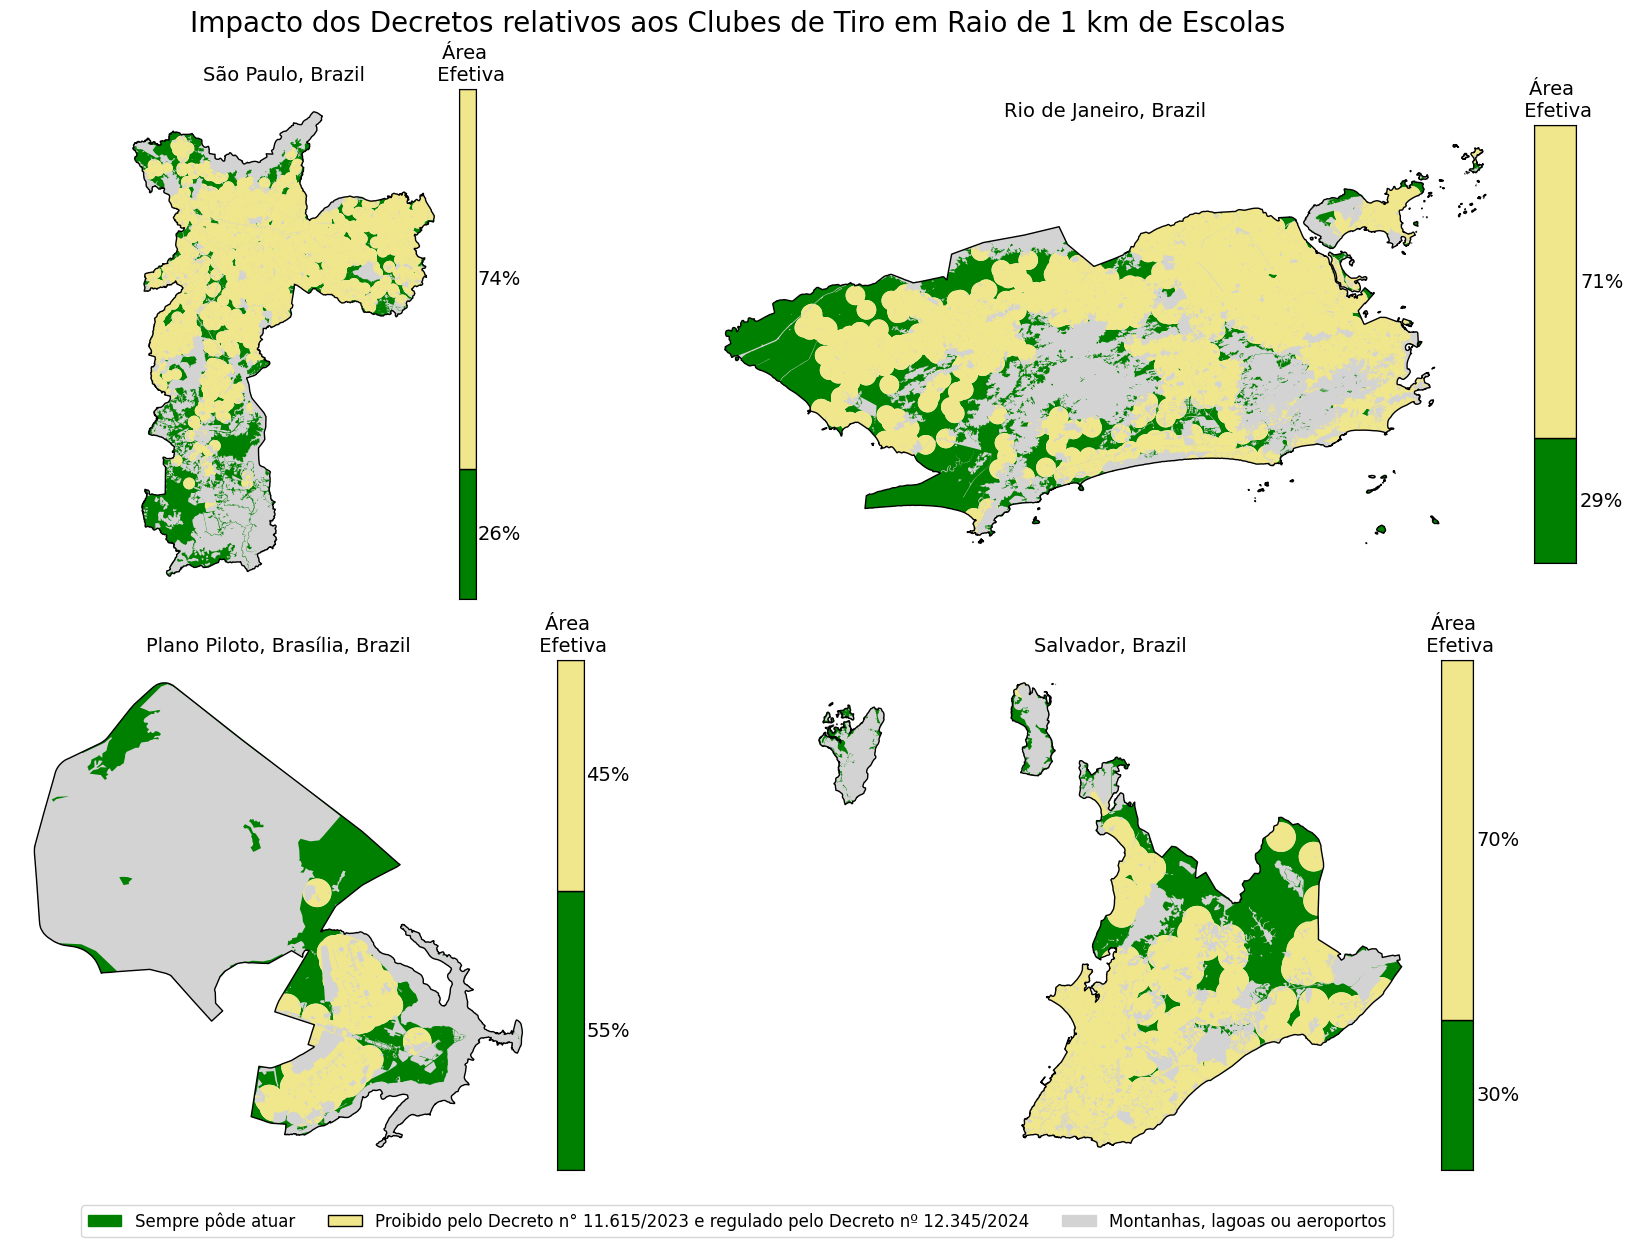

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Impacto dos Decretos relativos aos Clubes de Tiro em Raio de 1 km de Escolas", fontsize=20)

# Preparação de *handles* para legenda
# (Vamos criar apenas dois retângulos para explicar as cores)
green_patch = mpatches.Patch(color='green', label='Sempre pôde atuar')
# Para amarelo com listras, precisamos usar hatch
yellow_striped_patch = mpatches.Patch(facecolor='khaki', edgecolor='black',
                                     label='Proibido pelo Decreto n° 11.615/2023 e regulado pelo Decreto nº 12.345/2024')
gray_patch = mpatches.Patch(color='lightgray', label='Montanhas, lagoas ou aeroportos')
# Única legenda no final
handles_legend = [green_patch, yellow_striped_patch, gray_patch]

for i, (city_name, city_polygon, city_minus_buffer, city_in_buffer, natural_areas) in enumerate(results):
    ax = axs[i//2, i%2]
    # Cria GeoDataFrames para plotar
    always_allowed_gdf = gpd.GeoDataFrame(geometry=[city_minus_buffer], crs="EPSG:4326")
    newly_allowed_gdf = gpd.GeoDataFrame(geometry=[city_in_buffer], crs="EPSG:4326")
    # Converte para EPSG:3857 (ou outro) para evitar problemas de aspect
    always_allowed_3857 = always_allowed_gdf.to_crs(epsg=3857)
    newly_allowed_3857 = newly_allowed_gdf.to_crs(epsg=3857)
    # E o contorno da cidade (opcional)
    city_outline = gpd.GeoDataFrame(geometry=[city_polygon], crs="EPSG:4326")
    city_outline_3857 = city_outline.to_crs(epsg=3857)
    # Plot “fora do buffer” em verde
    always_allowed_3857.plot(ax=ax, color='green', edgecolor='none')
    # Plot “dentro do buffer” em amarelo listrado
    newly_allowed_3857.plot(ax=ax, facecolor='khaki')
    # Plot áreas naturais
    if not natural_areas.empty:
        natural_areas_3857 = natural_areas.to_crs(epsg=3857)
        natural_areas_3857.plot(ax=ax, color='lightgray')

    # Contorno da cidade
    city_outline_3857.plot(ax=ax, facecolor='none', edgecolor='black')

    # Barra pra mostrar a divisão da cidade
    # 1. Área total da cidade
    total_area = city_outline_3857.area[0]

    # 2. Área natural efetiva (cinza) - fica por cima de tudo
    natural_area = natural_areas_3857.area.sum() if not natural_areas.empty else 0
    total_area = total_area - natural_area

    # 3. Área regulada (amarela/khaki) - perde área para a natural
    regulated_area = newly_allowed_3857.area.sum() - (
                        natural_areas_3857.overlay(newly_allowed_3857, how='intersection').area.sum() 
                                                      if not natural_areas.empty else 0)
    
    # 4. Área base (verde) - perde área para as duas anteriores
    base_area = total_area - regulated_area
    
    percentages = {'Base': (base_area / total_area) * 100, 
                   'Regulado': (regulated_area / total_area) * 100}
    
    ax_divider = make_axes_locatable(ax)
    ax_bar = ax_divider.append_axes("right", size="5%", pad=0.1)
    
    # Criando visualmente a barra vertical empilhada
    values = [percentages['Base'], percentages['Regulado']]
    bottom_values = [0, percentages['Base']]
    colors = ['green', 'khaki']
    for value, bottom, color in zip(values, bottom_values, colors):
        if value > 0:
            ax_bar.bar(x=0, height=value, bottom=bottom, width=1, color=color, edgecolor='black')
            ax_bar.text(0.6, bottom + value/2, f'{value:.0f}%', va='center', ha='left', fontsize=14)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xlim(-0.5, 0.5)
    ax_bar.set_xticks([])
    ax_bar.set_yticks([])
    ax_bar.set_title('Área \n Efetiva', fontsize=14)

    # Ajustes gerais
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(city_name, fontsize=14)
    ax.set_axis_off()

# Criando a legenda única no centro (ou "lower center" / "center")
# Usamos a função fig.legend, pra figura inteira
fig.legend(handles=handles_legend, loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # ajusta conforme necessário
    ncol=3,  # três colunas para a legenda
    fontsize=12)

plt.tight_layout()
plt.show()